### 1. Downloading a linear optimization solver

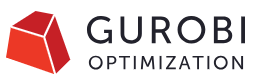

Downloading a linear optimization solver, I use Gurobi. You can access an Academic license via this page https://www.gurobi.com/features/academic-named-user-license/. You might need to be connected to eduroam to do this, or use the University VPN.

### 2. Downloading packages for constraint-based modelling and visualisation etc

Probably the minimum packages you will need are COBRA (for modelling), numpy, pandas and matplotlib for visualisation, but if you find more you like then by all means install them! You can either install directly using Anaconda Navigator, or using pip install in this notebook. I will print the version I have so we are working with the same versions -->

In [11]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cobra
print('numpy version:',np.__version__)
print('pandas version:',pd.__version__)
print('matplotlib version:',matplotlib.__version__)
print('cobra version:',cobra.__version__)

numpy version: 1.26.4
pandas version: 2.2.1
matplotlib version: 3.8.4
cobra version: 0.29.0


### 3. Importing model into this notebook

To import the genome-scale model into this notebook, you need to have originally saved it as an XML file from BioModels inside the same folder in which you have opened this Jupyter notebook. Here we can try beginning with a yeast model, so we will use the Yeast8 model https://www.ebi.ac.uk/biomodels/BIOMD0000001063#Files. 

All of the work from now on is from the COBRA toolbox, so I will give you some starter code here and then you can find your own in the toolbox. The section for loading and exploring the model is '1. Getting started' and the section for running flux balance analysis (FBA) and changing the objective function is '5. Simulating with FBA' and '5.2. Changing the objectives' https://cobrapy.readthedocs.io/en/latest/index.html

Here is a link to the COBRA github as well where you can find other tutorials: https://github.com/opencobra/cobrapy

In [173]:
from cobra.io import read_sbml_model #function for reading the model into Jupyter
model = read_sbml_model('yeast-GEM.xml') #make sure the file name here matches what model is saved as in folder
model #also, if you ever start getting weird changes when solving the model just re-run this cell and it'll reset the model

Name,M_yeastGEM_v8__46__5__46__0
Memory address,18f25959350
Number of metabolites,2742
Number of reactions,4058
Number of genes,1161
Number of groups,1
Objective expression,1.0*r_2111 - 1.0*r_2111_reverse_58b69
Compartments,"cell envelope, cytoplasm, extracellular, mitochondrion, nucleus, peroxisome, endoplasmic reticulum, Golgi, lipid particle, vacuole, endoplasmic reticulum membrane, vacuolar membrane, Golgi membrane, mitochondrial membrane"


### 4. Exploring model and beginning flux balance analysis

In [17]:
print('current model objective function:','\n',model.objective)

current model objective function: 
 Maximize
1.0*r_2111 - 1.0*r_2111_reverse_58b69


The above cell print that the reaction 'r_2111' is the in-built objective function, but what is this reaction?

In [22]:
model.reactions.get_by_id('r_2111')

Reaction identifier,r_2111
Name,growth
Memory address,0x18f20f1ac50
Stoichiometry,s_0450[c] --> biomass [cytoplasm] -->
GPR,
Lower bound,0.0
Upper bound,1000.0


So, above, we can see that the model is currently optimized for maximal growth. This makes sense seeing as it is a Yeast cell model. This is also the case for most genome-scale models, but we are exploring whether this is 'right' for every system or not! Let's see what the flux (a.k.a reaction rate) is if we solve FBA on the unconstrained model and print the flux through growth:

In [207]:
solution = model.optimize() #function for running flux balance analysis
print('growth of the cell when optimised for cell growth:',solution.objective_value,
      'mmol/gDW/hour, i.e.',1/(solution.objective_value),'cell divisions per hour')
#another way to print this is to search for the growth reaction amongst the dataframe of all predicted reaction rates:
print(solution.fluxes['r_2111']) #inside the square brackets you can input any reaction id

growth of the cell when optimised for cell growth: 0.08374773476923719 mmol/gDW/hour, i.e. 11.94062147179803 cell divisions per hour
0.08374773476923719


Let's search for the flux through other model reactions in this FBA solution and see what some of the reactions are...

In [145]:
solution_df = solution.to_frame()
reactions = []
for n in range(len(solution_df)): #make a loop to go row-by-row through the dataframe
    reactions.append(model.reactions.get_by_id((solution_df.index.to_list())[n]).reaction)
solution_df['reactions'] = reactions
original_solution_df = solution_df #save this original distribution so that we can access it later
original_solution_df

,fluxes,reduced_costs,reactions
r_0001,0.000000,0.000000e+00,s_0025[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + ...
r_0002,0.000000,-2.602085e-18,s_0027[m] + 2.0 s_0709[m] --> 2.0 s_0710[m] + ...
r_0003,0.000000,0.000000e+00,s_0035[c] + s_1198[c] <=> s_0020[c] + s_0794[c...
r_0004,0.000000,-2.602085e-18,s_0063[c] + 2.0 s_0709[m] --> 2.0 s_0710[m] + ...
r_0005,0.062686,-1.149254e-17,s_1543[c] --> s_0001[ce] + s_0794[c] + s_1538[c]
...,...,...,...
r_4694,0.000000,0.000000e+00,s_4258[c] --> s_4259[e]
r_4695,0.000000,0.000000e+00,s_4259[e] -->
r_4697,0.000000,-0.000000e+00,s_4253[m] <=> s_4261[c]
r_4698,0.000000,-1.672121e-01,s_4261[c] --> s_4262[e]


To make it a bit easier to understand these reactions, we can either input the metabolite id (e.g. s_0025[c]) into 'model.metabolites.get_by_id(s_0025[c])' or we can make a dictionary to search through:

In [57]:
metabolite_dictionary = {}
for m in model.metabolites:
    metabolite_dictionary[m.id] = m.name

#an example metabolite from the above table
print(metabolite_dictionary['s_0025[c]'])

(R)-lactate [cytoplasm]


Let's have a think about the different ways in which we can explore the model's current state, so that when we make changes to the objective function we can see the effect it is having. One way is by printing a summary of the model which gives you some tables:

In [59]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
s_0420[e],r_1654,0.5988,0,0.00%
s_0565[e],r_1714,1,6,100.00%
s_0796[e],r_1832,0.04236,0,0.00%
s_0925[e],r_1861,2.63E-06,0,0.00%
s_1277[e],r_1992,2.25,0,0.00%
s_1324[e],r_2005,0.5449,0,0.00%
s_1374[e],r_2020,0.000304,0,0.00%
s_1438[e],r_2049,0.0003325,0,0.00%
s_1468[e],r_2060,0.007203,0,0.00%
s_4200[e],r_4593,0.000108,0,0.00%


If you'd like, you can just look at the uptakes or secretions from the model summary:

In [174]:
summary = model.summary()
original_uptakes = summary.uptake_flux #save uptakes as a variable so we can access later
original_secretions = summary.secretion_flux #save secretions as a variable so we can access later
print(original_secretions)

        flux reaction metabolite
r_1542   0.0   r_1542  s_0003[e]
r_1545   0.0   r_1545  s_0022[e]
r_1546   0.0   r_1546  s_0026[e]
r_1547   0.0   r_1547  s_0029[e]
r_1548   0.0   r_1548  s_0032[e]
...      ...      ...        ...
r_4677   0.0   r_4677  s_4249[e]
r_4689   0.0   r_4689  s_4255[e]
r_4692   0.0   r_4692  s_4257[e]
r_4695   0.0   r_4695  s_4259[e]
r_4699   0.0   r_4699  s_4262[e]

[246 rows x 3 columns]


### 5. Changing the objective function

Here I will give you an example of changing the objective function and see what effects this has on the model, then hopefully you can begin to explore it yourself! :)

In [65]:
print('the current model objective function is:',model.objective)

the current model objective function is: Maximize
1.0*r_2111 - 1.0*r_2111_reverse_58b69


Given yeast are used to produce ethanol when we make beer, maybe this could be a suitable objective function! Let's find that reaction

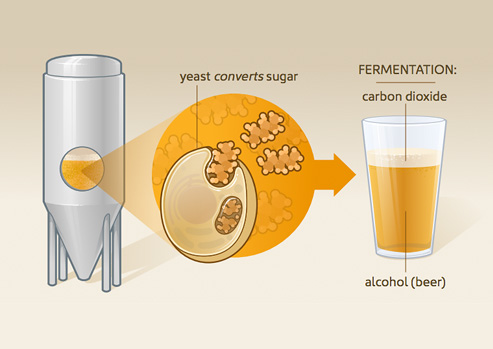

We are going to try and find the alcohol fermentation reaction in the model, sometimes this can take a bit of reading and digging around! (https://www.nature.com/scitable/topicpage/yeast-fermentation-and-the-making-of-beer-14372813/ and https://www.khanacademy.org/test-prep/mcat/physical-sciences-practice/x04f6bc56:foundation-5-chemical-processes/e/enzyme-structure-and-function---passage-2)

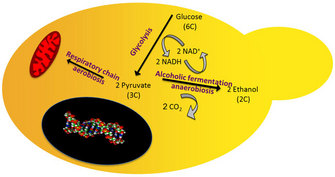 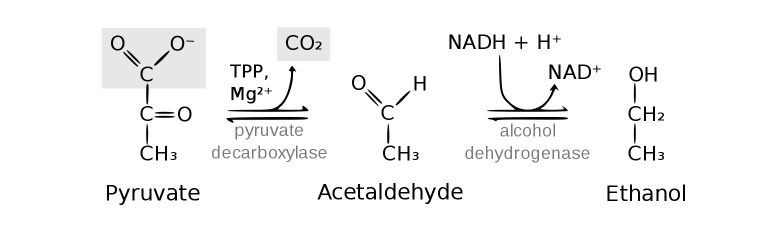

First we will search through model metablites to find which IDs correspond to the reactants and products involved in alcohol fermentation, which are described above:

In [136]:
for k,v in metabolite_dictionary.items():
    if 'pyruvate' in v: #the reactant in the alcohol fermentation reaction above
        print(k,v)
    if 'ethanol' in v: #the product in the alcohol fermentation reaction above
        print(k,v)
    if 'acetaldehyde' in v: #if you don't know the metabolite name, might have to play around with what's in the brackets here, like searching for 'co2' instead of 'carbon dioxide'
        print(k,v)
#N.B. for metablites which might instead be written as formula, it would be helpful to refer back to your metabolite dictionary to see how the name is written, e.g. 'co2' instead of 'carbon dioxide'

s_0185[c] 2-phenylethanol [cytoplasm]
s_0186[e] 2-phenylethanol [extracellular]
s_0187[m] 2-phenylethanol [mitochondrion]
s_0204[c] 3-(4-hydroxyphenyl)pyruvate [cytoplasm]
s_0206[p] 3-(4-hydroxyphenyl)pyruvate [peroxisome]
s_0258[c] 3-phospho-hydroxypyruvate [cytoplasm]
s_0359[c] acetaldehyde [cytoplasm]
s_0360[e] acetaldehyde [extracellular]
s_0361[m] acetaldehyde [mitochondrion]
s_0417[c] aminoacetaldehyde [cytoplasm]
s_0474[c] CDP-ethanolamine [cytoplasm]
s_0680[c] ethanol [cytoplasm]
s_0681[e] ethanol [extracellular]
s_0682[m] ethanol [mitochondrion]
s_0683[c] ethanolamine [cytoplasm]
s_0684[e] ethanolamine [extracellular]
s_0850[c] indol-3-ylacetaldehyde [cytoplasm]
s_0851[e] indol-3-ylacetaldehyde [extracellular]
s_0852[m] indol-3-ylacetaldehyde [mitochondrion]
s_0855[c] indole-3-pyruvate [cytoplasm]
s_0951[c] keto-phenylpyruvate [cytoplasm]
s_1239[c] O-phosphoethanolamine [cytoplasm]
s_1240[er] O-phosphoethanolamine [endoplasmic reticulum]
s_1318[c] phenylacetaldehyde [cytoplasm

Something which you might notice above are the different organelles, or model 'compartments' which one metabolite could be in. If we do some googling, we can find out that alcohol fermentation occurs in the cytoplasm (you can ask me if any of the biology is confusing), so this will help us reduce the above list further:

In [137]:
for k,v in metabolite_dictionary.items():
    if 'pyruvate' in v:
        if '[cytoplasm]' in v: #add this extra line of code to search the organelle, or 'compartment'
            print(k,v)
    if 'ethanol' in v:
        if '[cytoplasm]' in v: #add this extra line of code to search the organelle, or 'compartment'
            print(k,v)
    if 'acetaldehyde' in v:
        if '[cytoplasm]' in v: #add this extra line of code to search the organelle, or 'compartment'
            print(k,v)

s_0185[c] 2-phenylethanol [cytoplasm]
s_0204[c] 3-(4-hydroxyphenyl)pyruvate [cytoplasm]
s_0258[c] 3-phospho-hydroxypyruvate [cytoplasm]
s_0359[c] acetaldehyde [cytoplasm]
s_0417[c] aminoacetaldehyde [cytoplasm]
s_0474[c] CDP-ethanolamine [cytoplasm]
s_0680[c] ethanol [cytoplasm]
s_0683[c] ethanolamine [cytoplasm]
s_0850[c] indol-3-ylacetaldehyde [cytoplasm]
s_0855[c] indole-3-pyruvate [cytoplasm]
s_0951[c] keto-phenylpyruvate [cytoplasm]
s_1239[c] O-phosphoethanolamine [cytoplasm]
s_1318[c] phenylacetaldehyde [cytoplasm]
s_1351[c] phosphatidylethanolamine backbone [cytoplasm]
s_1360[c] phosphoenolpyruvate [cytoplasm]
s_1399[c] pyruvate [cytoplasm]
s_3967[c] Imidazole-4-acetaldehyde [cytoplasm]
s_3971[c] 5-Hydroxyindoleacetaldehyde [cytoplasm]
s_3979[c] Chloroacetaldehyde [cytoplasm]
s_4123[c] methanol [cytoplasm]
s_4244[c] (4-hydroxyphenyl)acetaldehyde [cytoplasm]


Looking through the list of metabolites above, we can take sensible guess that 'ethanol [cytoplasm]' with the ID 's_0680[c]' refers to the alcohol which is produced during fermentation. So now we will search through the model reactions to find the reaction describing the reduction of acetaldehyde ('s_0359[c]' listed above) to alcohol:

In [142]:
for r in model.metabolites.get_by_id('s_0680[c]').reactions: #code to search through reactions for this metabolite
    if 's_0359[c]' in r.reaction: #search for those reactions also metabolising acetaldehyde
        print(r.name,r)

alcohol dehydrogenase, (acetaldehyde to ethanol) r_2115: s_0359[c] + s_0794[c] + s_1203[c] --> s_0680[c] + s_1198[c]
alcohol dehydrogenase (ethanol to acetaldehyde) r_0163: s_0680[c] + s_1198[c] --> s_0359[c] + s_0794[c] + s_1203[c]


Now we will assign this reaction to a variable so that we don't lose it!

In [143]:
alcohol_fermentation = model.reactions.get_by_id('r_2115')

Now we've found the reaction for alcohol fermentation, we will change the objective function from growth to this reaction, and have a look at how it changes some of the model outputs...

In [172]:
with model: #use 'with model:' to make impermanent changes to your model, i.e. in a new cell the model should revert back to original objective function
    model.objective = alcohol_fermentation #change the objective
    print(model.objective) #check objective has been changed
    new_solution = model.optimize() #run fba
    new_growth = new_solution.fluxes['r_2111'] #this was the reaction ID for growth which was saw above
    new_summary = model.summary() #save new model outputs for comparison to original optimisation
    new_uptakes = new_summary.uptake_flux
    new_secretions = new_summary.secretion_flux

new_solution_df = new_solution.to_frame()
reactions = []
for n in range(len(new_solution_df)): #make a loop to go row-by-row through the dataframe and add the reaction equations
    reactions.append(model.reactions.get_by_id((new_solution_df.index.to_list())[n]).reaction)
new_solution_df['reactions'] = reactions

Maximize
1.0*r_2115 - 1.0*r_2115_reverse_9fd11


Let's see how the growth of the yeast cell is predicted to have changed now that it has been optimised for alcohol fermentation rather than growth:

In [158]:
print('growth under growth optimisation:',solution.fluxes['r_2111'],'g/gDW/hour')
print('growth under fermentation optimisation:',new_solution.fluxes['r_2111'],'g/gDW/hour')

growth under growth optimisation: 0.08374775787264979 g/gDW/hour
growth under fermentation optimisation: 0.0 g/gDW/hour


The cell is no longer predicted to grow once we've picked a different objective! This might not be the case for other models, or under different media conditions, or for other organisms...but you can begin to see how we can compare the output of differently optimised models :)

A good sanity check would be to see if fermentation has actually increased once we have changed this objective:

In [159]:
print('fermentation under growth optimisation:',solution.fluxes['r_2115'],'mmol/gDW/hour')
print('fermentation under fermentation optimisation:',new_solution.fluxes['r_2115'],'mmol/gDW/hour')

fermentation under growth optimisation: 0.0 mmol/gDW/hour
fermentation under fermentation optimisation: 1000.0 mmol/gDW/hour


Now why don't we see how what the cell takes in, i.e. what metabolites are being transported from the extraccellular space (the media or surroundings) to the cystosol for the cell under fermentation optimisation conditions. To make this clearer we will first convert the metabolite IDs to metablite names and add this as a column to the uptake dataframes:

In [189]:
original_metabolite_names = []
for n in range(len(original_uptakes)):
    original_metabolite_names.append(model.metabolites.get_by_id(original_uptakes.iloc[n,2]).name)
original_uptakes['metabolite_names'] = original_metabolite_names

new_metabolite_names = []
for n in range(len(new_uptakes)):
    new_metabolite_names.append(model.metabolites.get_by_id(new_uptakes.iloc[n,2]).name)
new_uptakes['metabolite_names'] = new_metabolite_names

Now we will put the fluxes from the original growth optimisation alongside the fluxes from the fermentation optimisation, ready for plotting:

In [194]:
original_to_new_df = pd.DataFrame()
original_to_new_df['metabolite'] = original_metabolite_names
original_to_new_df['original_flux'] = original_uptakes['flux'].to_list()
new_uptakes_list = []
for uptake in original_uptakes.index.to_list():
    if uptake in new_uptakes.index:
        new_uptakes_list.append(new_uptakes.loc[uptake]['flux'])
    if uptake not in new_uptakes.index:
        new_uptakes_list.append(new_solution_df.loc[uptake]['fluxes'])
original_to_new_df['new_flux'] = new_uptakes_list
original_to_new_df = original_to_new_df.set_index('metabolite')
original_to_new_df

,original_flux,new_flux
metabolite,,
ammonium [extracellular],0.598776,0.000000e+00
D-glucose [extracellular],1.000000,3.647353e-02
H+ [extracellular],0.042356,2.196327e-14
iron(2+) [extracellular],0.000003,0.000000e+00
oxygen [extracellular],2.250053,2.188412e-01
phosphate [extracellular],0.544949,0.000000e+00
potassium [extracellular],0.000304,0.000000e+00
sodium [extracellular],0.000332,0.000000e+00
sulphate [extracellular],0.007203,0.000000e+00


Now we can visualise the dataframe above onto a bar plot which will be clearer:

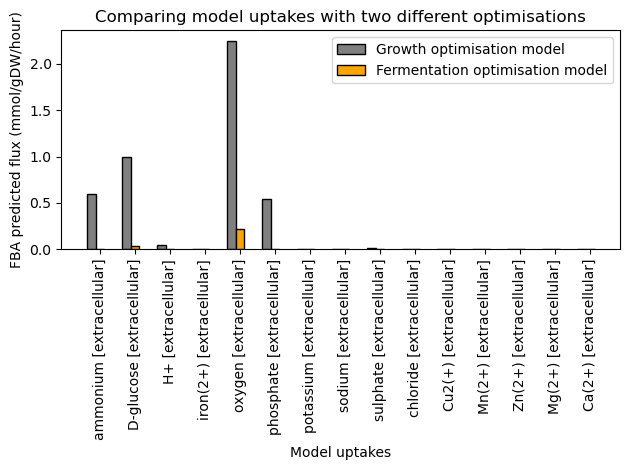

In [206]:
#DISCALIMER: I use CHATGPT and CLAUDE to help me make nice plots with matplotlib so feel free to do this too!! :)
groups = original_to_new_df.index.to_list()
growth_optimisation = original_to_new_df['original_flux'].to_list()
fermentation_optimisation = original_to_new_df['new_flux'].to_list()

# Number of groups and bar width
n_groups = len(groups)
bar_width = 0.25
x = np.arange(n_groups)  # Group positions on the x-axis

# Plotting
plt.bar(x, growth_optimisation, width=bar_width, label='Growth optimisation model', color='grey',edgecolor='black')
plt.bar(x + bar_width, fermentation_optimisation, width=bar_width, label='Fermentation optimisation model', color='orange',edgecolor='black')

# Customization
plt.xlabel('Model uptakes')
plt.ylabel('FBA predicted flux (mmol/gDW/hour)')
plt.title('Comparing model uptakes with two different optimisations')
plt.xticks(x + bar_width, groups, rotation=90)  # Set x-axis labels in the middle of grouped bars
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

So now you've done it, you've got a simple model of a yeast which is adapted for maximal growth, and one which is adapted for maximal fermentation, and actually isn't growing at all! When you look through this bar plot, you can see that the fermenting cell uses a lot less oxygen than the growing cell, which makes sense, because fermentation is an anaerobic process (meaning it does not use oxygen). Also, when the cell is fermenting and not growing, it takes up a lot less glucose. This is an example of how you can play with the objective function, report the results, and then discuss them. But you can change the objective function in lots of different ways and assess how this affects the flux distribution. For example, you could do some unsupervised clustering or some statistics

Some more ideas of how you can change the objective function are as follows, but we can adapt this over the course of the project depending on what is working and what you find interesting:
- Using a linear, multi-objective function, with a 50:50 split
- Selecting a multi-objective function, but playing with the ratio of reaction 1: reaction 2
- Writing a quadratic objective function
- Working with a 'sub-optimal' objective function, where we might solve for 95% optimal growth, for example
- And all the while we can compare to publicly available growth data and flux data :)